![Inicio](doc/inicio.png)

## **Trabajo Final**

## Yoga Pose Estimation 

## Autor: Juan Ignacio Ribet

### Director:  Juan Pablo Pizarro (Globant)

### Programa de vinculacion con empresa Globant

Resumen

La presente memoria describe el desarrollo de un detector de postura de yoga o
asanas para la empresa Globant. Este trabajo pretende obtener el mínimo
producto viable de una aplicación para entrenamiento de yoga, en donde se
detecte la postura mediante algoritmos de aprendizaje de máquina y visión por
computadora, y se le de soporte al usuario para realizarlas de forma correcta.

Para su desarrollo fueron fundamentales los conocimientos adquiridos en la
carrera, en especial los vistos en las materias de visión por computadora con el
uso indispensable de la librería OpenCV como también los conceptos de
aprendizaje de máquina, análisis de datos y la comprensión del mecanismo de
funcionamiento de las de las redes neuronales convolucionales.

## Tabla de contenido
----

1.	Planteo del problema<br>
2.	Visualización de los datos<br>
3.	Creación del dataset para entrenar<br>
3.1.	Generación de cada dataset<br>
4.	Carga de los datasets generados<br>
5.	Verificación del balance de clases<br>
6.	Entrenamiento de los modelos<br>
7.	Verificación de modelo con imágenes de validación<br>
8.	Matriz de confusión en set de prueba<br>
9.	Optuna: Optimización de hiperparametros<br>
10.	Estimación de posturas en video<br>
11.	Interfaz<br>



# Planteo del problema

Este trabajo tiene un objetivo primario: el desarrollo de un prototipo de aplicación, que cuente con la función de detectar las posturas de yoga, utilizando las herramientas disponibles en visión por computadora, aprendizaje de maquina y análisis de datos. El sistema deberá poder ser utilizado en dispositivos de bajos recursos computacionales, que a su vez dispongan de cámara web para la obtención de los videos. Estas dos condiciones son necesarias pues la detección tiene que ser realizada en tiempo real. Complementando la detección el modelo buscará mostrar referencias visuales al usuario que lo ayuden a lograr la postura correctamente.

Este prototipo implica tambien el desarrollo de una interfaz simple y funcional.

In [1]:
# Import the necessary libraries
import csv
import cv2
import math
import optuna
import os
import pathlib
import pickle
import platform
import random
import sys
import time
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import iglob


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import svm

import mediapipe as mp

c:\Users\juani\.virtualenvs\Trabajo_Final-IPaO5b2r\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Descarga del Dataset

### Download Dataset

In [27]:
# Unzip and download dataset

if os.access('./DATASET', os.F_OK) is False:
    if os.access('DATASET.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://github.com/Juaniribet/Vision_Computadora_II_CEIA/main/DATASET.zip -o DATASET.zip
        else:
            !wget DATASET.zip https://github.com/Juaniribet/Vision_Computadora_II_CEIA/raw/main/DATASET.zip
    import zipfile
    with zipfile.ZipFile('DATASET.zip','r') as zip_ref:
        zip_ref.extractall()
else:
    print("El dataset ya se encuentra descargado")

### Visualización de los datos

Definición de variables y visualización de cada clase

### Data vizualization

Definition of variables and visualization of each class

In [2]:
if 'google.colab' in sys.modules:
  train_folder = '/content/DATASET/TRAIN'
  test_folder = '/content/DATASET/TEST'
  valid_folder = '/content/DATASET/VALID'
  dataset_folder = '/content/DATASET'
else:
  train_folder = 'DATASET/TRAIN'
  test_folder = 'DATASET/TEST'
  valid_folder = 'DATASET/VALID'
  dataset_folder = 'DATASET'

CLASES = []
for class_name in os.listdir(train_folder):
  CLASES.append(class_name)

CANTIDAD_CLASES = len(CLASES)

print(f'CLASSES: {CLASES}')
print(f'CLASSES_QUANTITY: {CANTIDAD_CLASES}')

CLASSES: ['downdog', 'goddess', 'tree', 'warrior']
CLASSES_QUANTITY: 4


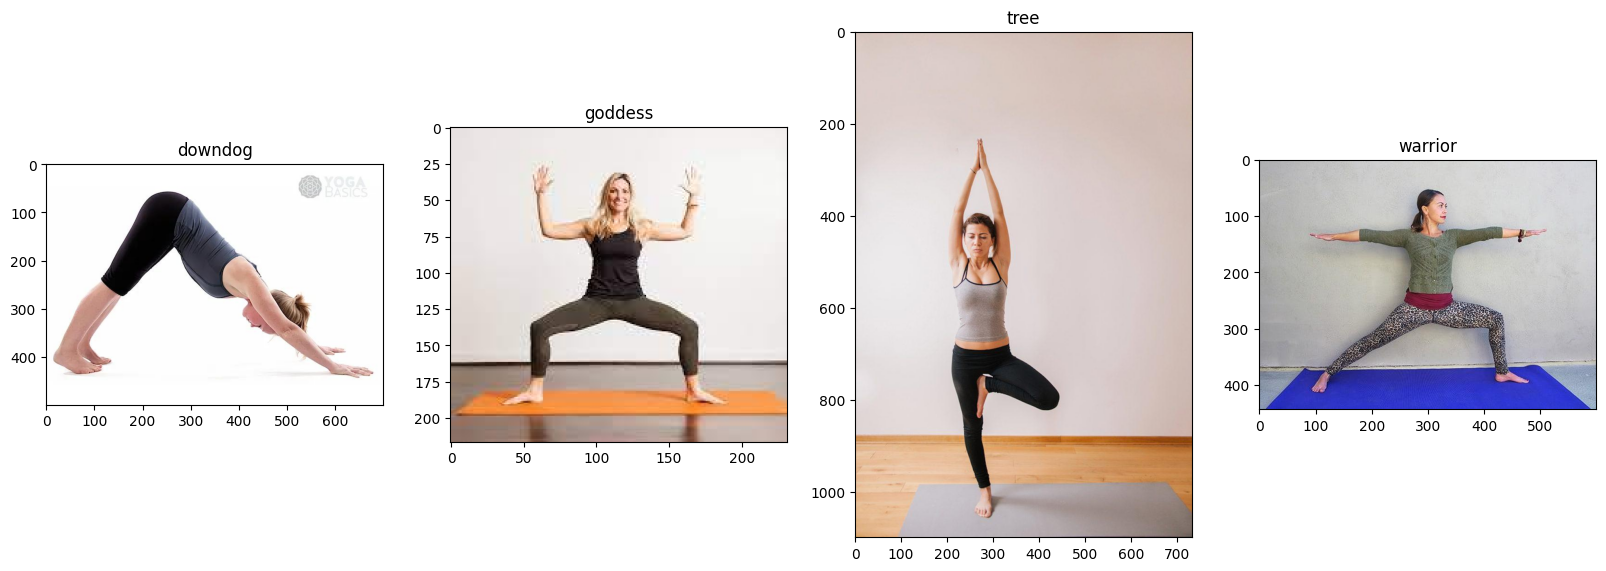

In [29]:
fig, axs = plt.subplots(1, CANTIDAD_CLASES, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

# Creación del dataset para entrenar

GetCoordsLandmarksImages: clase para generar los dataset de coordenadas de los puntos claves del modelo de MediaPipe desde las imagenes

## Creation of the dataset to train

GetCoordsLandmarksImages: class to generate the coordinate dataset of the key points of the MediaPipe model from the images

In [22]:
class GetCoordsLandmarksImages():

    '''class to obtain the coordinates of the landmarks form body images  using MediaPipe-Pose
    framework'''

    def __init__(self):

        self.file_list_used= []
        self.mp_pose = mp.solutions.pose # Mediapipe Solutions
        pass

    def create_csv_file(self, file_name: str):

        '''"file_name": The name of the csv file as it will be stored. ("file_name.csv").'''

        self.file_name = file_name + '.csv'

        landmarks = ['class', 'path']
        for val in range(0, 33):
            landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

        with open(file_name + '.csv', mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(landmarks)


    def get_coord(self, rootdir: str, class_name = None, file_name = None):

        '''
        Create a dataset with the coord of the landmarks of the images or videos stored in "rootdir"

        "rootdir": Path of the folder where the images or videos are stored.

        "class_name" : str, default = None - If not given, will be the folder name where the images
        or video are stored.

        "file_name" : str, default = None - If not given, the file created in "create_csv_file()"
        will be used.

        "min_detection_confidence" : mp_pose min_detection_confidence (default = 0.6).

        "min_tracking_confidence": mp_pose min_detection_confidence (default = 0.6).

        '''

        self.rootdir_glob = rootdir

        if file_name == None:
            file_name = self.file_name

        path_files_list = [f for f in iglob(rootdir, recursive=True) if os.path.isfile(f)]

        for path in path_files_list:

            image = cv2.imread(path)

            if class_name == None:
                class_name = pathlib.PurePath(os.path.normpath(path))
                class_name = class_name.parent.name


            with self.mp_pose.Pose(static_image_mode=True,
                                    min_detection_confidence=0.5) as pose:

                try:
                    # Recolor Feed
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image.flags.writeable = False

                    # Make Detections
                    results = pose.process(image)

                    # Recolor image back to BGR for rendering
                    image.flags.writeable = True
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Export coordinates

                    # Extract Pose landmarks
                    poses = results.pose_landmarks.landmark
                    pose_row = list(np.array(
                        [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                         for landmark in poses]).flatten())

                    # Append class name
                    pose_row.insert(0, class_name)
                    pose_row.insert(1, path)
                    self.file_list_used.append(path)

                    # Export to CSV
                    with open(file_name, mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"',
                                                quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(pose_row)

                except:
                    pass

    def bad_images(self):

        '''Return the images that are bad for detection'''

        path_files_list = [f for f in iglob(self.rootdir_glob, recursive=True)
                           if os.path.isfile(f)]


        images_not_used=[]
        for j in path_files_list:
            if j not in self.file_list_used:
                images_not_used.append(j)

        print(f'{len(images_not_used)} bad images of {len(path_files_list)}')

        if len(images_not_used) > 0:
            print(images_not_used)

### Generación de cada Dataset

### Generation of each Dataset

In [23]:
get_data = GetCoordsLandmarksImages()
get_data.create_csv_file('coord_dataset_csv/df_downdog_train')
get_data.get_coord(train_folder + '/downdog/*', class_name='downdog')
get_data.bad_images()

0 bad images of 228


In [24]:
get_data.create_csv_file('coord_dataset_csv/df_downdog_test')
get_data.get_coord(test_folder +'/downdog/*', class_name='downdog')
get_data.bad_images()

0 bad images of 57


In [25]:
get_data.create_csv_file('coord_dataset_csv/df_goddess_train')
get_data.get_coord(train_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 213


In [26]:
get_data.create_csv_file('coord_dataset_csv/df_goddess_test')
get_data.get_coord(test_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 54


In [27]:
get_data.create_csv_file('coord_dataset_csv/df_tree_train')
get_data.get_coord(train_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 222


In [28]:
get_data.create_csv_file('coord_dataset_csv/df_tree_test')
get_data.get_coord(test_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 56


In [29]:
get_data.create_csv_file('coord_dataset_csv/df_warrior_train')
get_data.get_coord(train_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 217


In [30]:
get_data.create_csv_file('coord_dataset_csv/df_warrior_test')
get_data.get_coord(test_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 55


### Carga de los datasets generados

#### Loading the generated datasets

In [16]:
df_downdog_train = pd.read_csv("coord_dataset_csv/df_downdog_train.csv")
df_downdog_test = pd.read_csv("coord_dataset_csv/df_downdog_test.csv")
df_goddess_train = pd.read_csv("coord_dataset_csv/df_goddess_train.csv")
df_goddess_test = pd.read_csv("coord_dataset_csv/df_goddess_test.csv")
df_tree_train = pd.read_csv("coord_dataset_csv/df_tree_train.csv")
df_tree_test = pd.read_csv("coord_dataset_csv/df_tree_test.csv")
df_warrior_train = pd.read_csv("coord_dataset_csv/df_warrior_train.csv")
df_warrior_test = pd.read_csv("coord_dataset_csv/df_warrior_test.csv")

Armado el dataset de entrenamiento

Assembled the training dataset

In [17]:
df_yoga_train = pd.concat([df_downdog_train, df_goddess_train,df_tree_train,df_warrior_train],
                          ignore_index=True)
# df_yoga_train['class'] = df_yoga_train['class'].replace(name_to_idx)
df_yoga_train

class                             path        x0        y0        z0  \
0    downdog  DATASET/TRAIN/downdog\00000.jpg  0.511189  0.727550 -0.076373   
1    downdog  DATASET/TRAIN/downdog\00001.jpg  0.568022  0.786379 -0.044425   
2    downdog  DATASET/TRAIN/downdog\00002.jpg  0.608902  0.736586 -0.031492   
3    downdog  DATASET/TRAIN/downdog\00003.jpg  0.541984  0.758109 -0.096469   
4    downdog  DATASET/TRAIN/downdog\00004.jpg  0.360903  0.700388 -0.033786   
..       ...                              ...       ...       ...       ...   
875  warrior  DATASET/TRAIN/warrior\00212.jpg  0.499194  0.384605 -0.111064   
876  warrior  DATASET/TRAIN/warrior\00213.jpg  0.584924  0.397947 -0.278694   
877  warrior  DATASET/TRAIN/warrior\00214.jpg  0.447357  0.221157 -0.378068   
878  warrior  DATASET/TRAIN/warrior\00215.jpg  0.518319  0.188786 -0.313877   
879  warrior  DATASET/TRAIN/warrior\00216.jpg  0.482947  0.204508 -0.106461   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.999087  0.494254  0.750801 -0.115903  0.999525  ...  0.349741   
1    0.999655  0.581655  0.794644 -0.024105  0.999690  ... -0.142834   
2    0.999770  0.629058  0.740810 -0.005169  0.999771  ... -0.146727   
3    0.999904  0.561617  0.768991 -0.074017  0.999896  ... -0.031129   
4    0.997857  0.340383  0.711678 -0.076438  0.998727  ...  0.364820   
..        ...       ...       ...       ...       ...  ...       ...   
875  0.999579  0.504037  0.371839 -0.114633  0.997423  ...  0.080119   
876  0.999918  0.581858  0.384461 -0.237754  0.999785  ... -0.003061   
877  0.999972  0.455515  0.199518 -0.348565  0.999860  ...  0.063277   
878  0.999998  0.527133  0.170191 -0.279705  0.999996  ... -0.141693   
879  0.999823  0.490771  0.186224 -0.112046  0.999126  ...  0.030736   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.572870  0.789083  0.920681 -0.254881  0.981300  0.775926  0.902560   
1    0.996496  0.248387  0.902885  0.072101  0.638526  0.238052  0.910098   
2    0.996390  0.212486  0.909015  0.215780  0.676139  0.201758  0.923530   
3    0.997919  0.276310  0.879952  0.286139  0.832718  0.262517  0.886805   
4    0.468797  0.745153  0.924358 -0.274635  0.975121  0.724463  0.912739   
..        ...       ...       ...       ...       ...       ...       ...   
875  0.996445  0.665906  0.831001 -0.126886  0.996586  0.388216  0.831052   
876  0.971639  0.776543  0.972285 -0.023407  0.989177  0.259307  0.982626   
877  0.988696  0.723612  0.927647 -0.309367  0.990107  0.138938  0.899099   
878  0.984783  0.714631  0.929704  0.347830  0.982268  0.324148  0.981388   
879  0.990055  0.717312  0.955993 -0.156758  0.985759  0.308552  0.927293   

          z32       v32  
0    0.247644  0.584526  
1   -0.274867  0.992569  
2   -0.320097  0.993469  
3   -0.191682  0.996327  
4    0.272612  0.477174  
..        ...       ...  
875  0.026301  0.992905  
876 -0.165598  0.995593  
877 -0.060792  0.985239  
878 -0.300075  0.997440  
879 -0.041138  0.982668  

[880 rows x 134 columns]

Armado el dataset de test

Assembled the test dataset

In [18]:
df_yoga_test = pd.concat([df_downdog_test, df_goddess_test,df_tree_test,df_warrior_test],
                         ignore_index=True)
# df_yoga_test['class'] = df_yoga_test['class'].replace(name_to_idx)
df_yoga_test

class                            path        x0        y0        z0  \
0    downdog  DATASET/TEST/downdog\00228.jpg  0.603251  0.714973 -0.026274   
1    downdog  DATASET/TEST/downdog\00229.jpg  0.577452  0.779198 -0.071213   
2    downdog  DATASET/TEST/downdog\00230.jpg  0.328606  0.771511 -0.063471   
3    downdog  DATASET/TEST/downdog\00231.jpg  0.542061  0.648875 -0.012753   
4    downdog  DATASET/TEST/downdog\00232.jpg  0.530507  0.742806  0.002176   
..       ...                             ...       ...       ...       ...   
217  warrior  DATASET/TEST/warrior\00267.jpg  0.484089  0.203997 -0.111081   
218  warrior  DATASET/TEST/warrior\00268.jpg  0.432160  0.198838 -0.387388   
219  warrior  DATASET/TEST/warrior\00269.jpg  0.421851  0.333012 -0.195190   
220  warrior  DATASET/TEST/warrior\00270.jpg  0.541960  0.253691 -0.311029   
221  warrior  DATASET/TEST/warrior\00271.jpg  0.464490  0.128971 -0.120755   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.999967  0.619374  0.720470 -0.013955  0.999962  ...  0.048538   
1    0.999935  0.597411  0.784217 -0.048661  0.999945  ... -0.133076   
2    0.995163  0.307143  0.767711 -0.104149  0.996052  ...  0.326164   
3    0.999859  0.552049  0.658177 -0.000413  0.999824  ... -0.067906   
4    0.999984  0.548443  0.760892  0.022248  0.999980  ...  0.118062   
..        ...       ...       ...       ...       ...  ...       ...   
217  0.999938  0.491651  0.187007 -0.113273  0.999716  ...  0.027554   
218  0.999968  0.444920  0.180878 -0.382607  0.999780  ... -0.089547   
219  0.999943  0.426797  0.317650 -0.201206  0.999601  ...  0.083238   
220  0.999986  0.536933  0.238940 -0.286740  0.999945  ...  0.058292   
221  0.999994  0.476415  0.108416 -0.128763  0.999979  ... -0.042618   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.996935  0.322599  0.879771  0.232244  0.893264  0.307449  0.904003   
1    0.989042  0.300147  0.862950  0.131157  0.526981  0.291627  0.873573   
2    0.524521  0.759748  0.902575 -0.291439  0.980245  0.749885  0.896683   
3    0.999538  0.377171  0.803991  0.091059  0.910834  0.372542  0.821747   
4    0.997261  0.239970  0.891590  0.304190  0.901485  0.220226  0.919155   
..        ...       ...       ...       ...       ...       ...       ...   
217  0.988865  0.714938  0.962638 -0.165509  0.989565  0.314849  0.930008   
218  0.991252  0.825170  0.791324  0.084845  0.978573  0.180136  0.781066   
219  0.995784  0.654345  0.939613 -0.251115  0.997821  0.275559  0.888648   
220  0.959162  0.698355  0.890077 -0.131697  0.993748  0.299599  0.913692   
221  0.991180  0.760931  0.926515 -0.194955  0.993155  0.229075  0.900245   

          z32       v32  
0   -0.050057  0.996111  
1   -0.275342  0.979802  
2    0.219774  0.497387  
3   -0.153075  0.999040  
4    0.005179  0.996371  
..        ...       ...  
217 -0.046122  0.984864  
218 -0.247969  0.989746  
219  0.037844  0.990626  
220 -0.088099  0.993308  
221 -0.155714  0.992226  

[222 rows x 134 columns]

División de los datsets

Division of the datasets

In [9]:
X_train = df_yoga_train.drop(columns=['class', 'path'])
y_train = df_yoga_train['class']
X_test = df_yoga_test.drop(columns=['class', 'path'])
y_test = df_yoga_test['class']

In [10]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

test_slip = int((X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)
train_slip = int((X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)


print(f'Split Train/Test: {int(train_slip)}%-{int(test_slip)}%')

X_train shape:  (880, 132)
X_test shape:  (222, 132)
y_train shape:  (880,)
y_test shape:  (222,)
Split Train/Test: 79%-20%


### Verificación del balance de clases

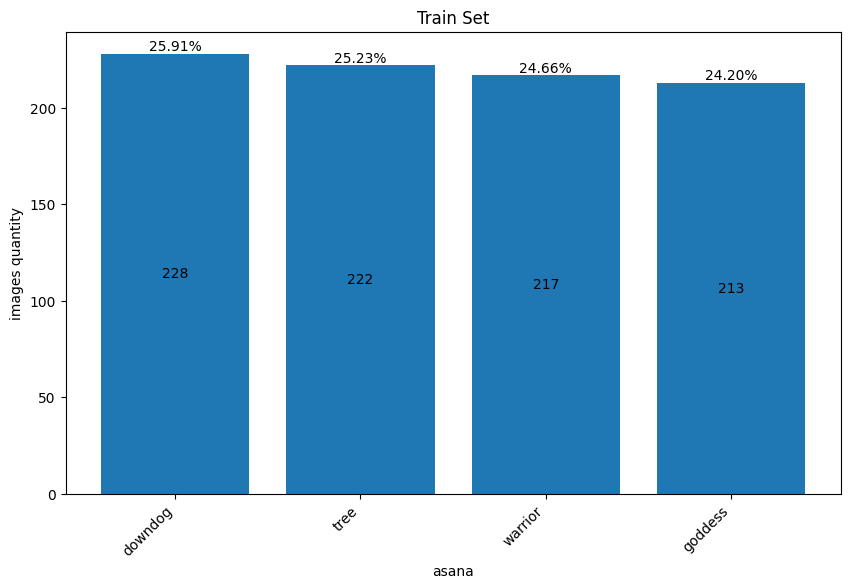

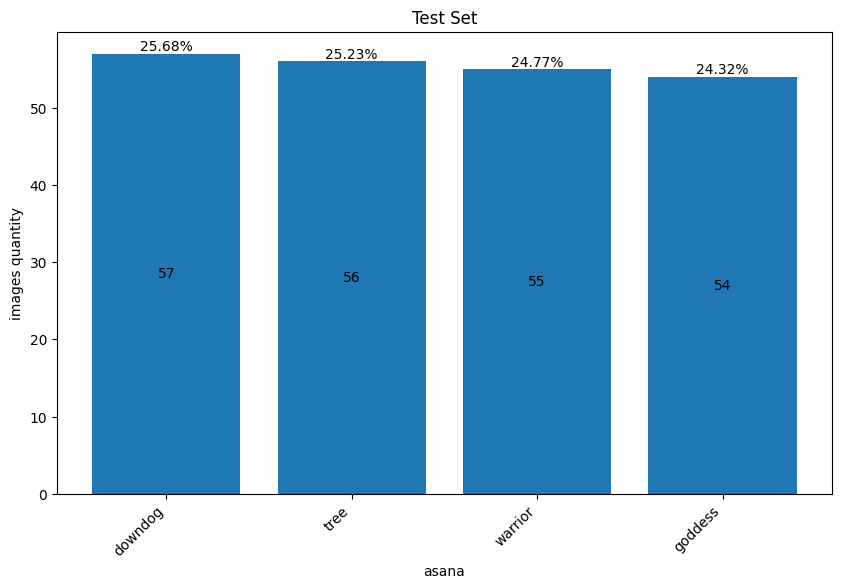

In [9]:
# Calcular counts y porcentajes
for i, set in zip((y_train, y_test), ('Train Set', 'Test Set')):
    valid_categories = i
    category_counts = valid_categories.value_counts()
    total_count = len(valid_categories)
    category_percentages = (category_counts / total_count) * 100

    # Grafico
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.index, category_counts)
    #bars = plt.bar(name_to_idx.keys, category_counts)
    plt.xlabel("asana")
    plt.ylabel("images quantity")
    plt.bar_label(bars, label_type='center')

    # Agregar porcentajes sobre las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        category = category_counts.index[i]
        if category in category_percentages:
            percentage = category_percentages[category]
            plt.text(bar.get_x() + bar.get_width() / 2,
                     height,
                     f"{percentage:.2f}%",
                     ha="center",
                     va="bottom")
    
    plt.xticks(rotation=45, ha="right")
    plt.title(str(set))
    plt.show()

# Entrenamiento de los modelos

## Model training

In [21]:
# Definicion de los modelos a entrenar
pipelines = {
    'lr':make_pipeline(StandardScaler(),LogisticRegression(max_iter = 500)),
    'lrcv': make_pipeline(StandardScaler(),LogisticRegressionCV(max_iter = 500)),
    'rf':make_pipeline(RandomForestClassifier()),
    'svm':make_pipeline(svm.SVC(probability=True)),
    'AdaBC':make_pipeline(AdaBoostClassifier()),
    'bagg':make_pipeline(BaggingClassifier()),
}

# Entrenamiento de los modelos
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

# Evaluación de los modelos
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(f'Accuracy {algo}: {accuracy_score(y_test, yhat):.5%}')

model = fit_models['svm']

Accuracy lr: 100.00000%
Accuracy lrcv: 100.00000%
Accuracy rf: 99.54955%
Accuracy svm: 99.54955%
Accuracy AdaBC: 45.49550%
Accuracy bagg: 97.74775%


Los modelos de Logistic Regression, Logistic Regression CV y Random Forrest tiene un accuracy muy alto. En principio se selecciona la arquitectura de LRCV pero posteriormente se analizará con el video de muestra para comparar resultados.

The Logistic Regression, Logistic Regression CV and Random Forrest models have a very high accuracy. For start, the LRCV architecture is selected but later it will be analyzed with the sample video to compare results.

In [58]:
# Save model for the interface
import pickle
with open('interface\pages\Data\models\yoga_pose_detection_model.pkl', 'wb') as f:
    pickle.dump(fit_models['svm'], f)

In [4]:
# Load model
with open('interface\pages\Data\models\yoga_pose_detection_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [22]:
# Save all the trained models
for model_name in list(fit_models.keys())[:4]:
    with open(f'models\\model_{model_name}.pkl', 'wb') as f:
        pickle.dump(fit_models[model_name], f)

In [10]:
for m  in os.listdir('models'):
    print(m)

model_lr.pkl
model_lrcv.pkl
model_rf.pkl
model_svm.pkl


In [8]:
# Load all the trained models
fit_models = {}
for m  in os.listdir('models'):
  with open(f'models\\{m}', 'rb') as f:
    fit_models[m[6:-4]] = pickle.load(f)
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression(max_iter=500))]),
 'lrcv': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregressioncv', LogisticRegressionCV(max_iter=500))]),
 'rf': Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())]),
 'svm': Pipeline(steps=[('svc', SVC(probability=True))])}

## Verificación de modelo con imagenes de validación

In [4]:
mp_pose = mp.solutions.pose # Mediapipe Solutions

landmarks = []
for val in range(0, 33):
            landmarks += ['x{}'.format(val),
                          'y{}'.format(val),
                          'z{}'.format(val),
                          'v{}'.format(val)]

### Verificación con las imágenes de validación

#### Verification with validation images

File name: downdog.jpg - Predicction: downdog


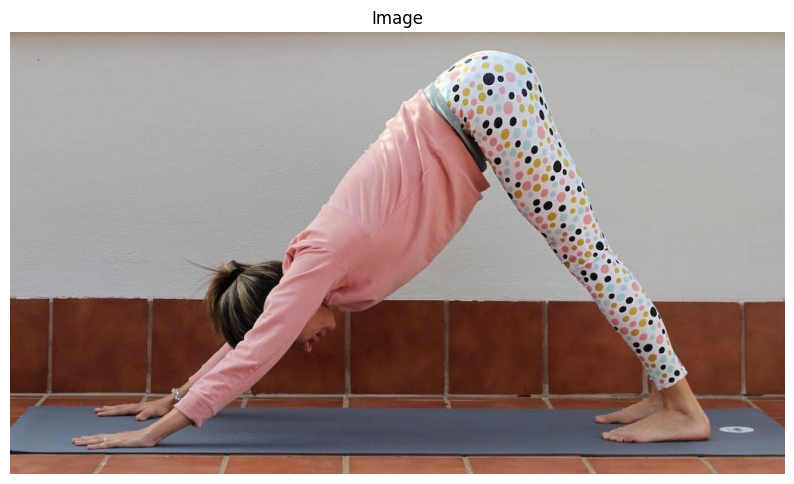

File name: goddess.jpg - Predicction: goddess


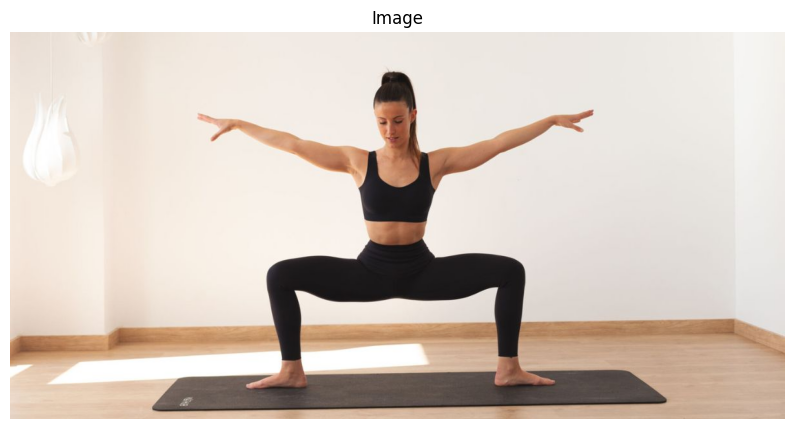

File name: tree.jpg - Predicction: tree


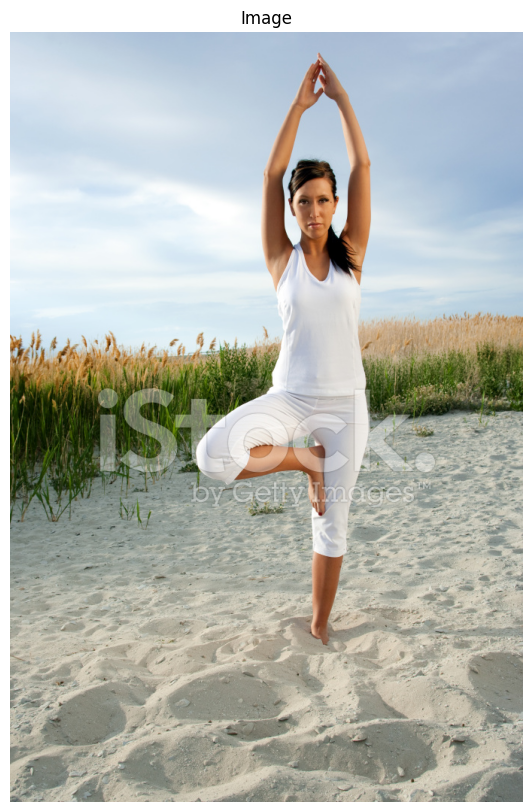

File name: warrior.jpg - Predicction: warrior


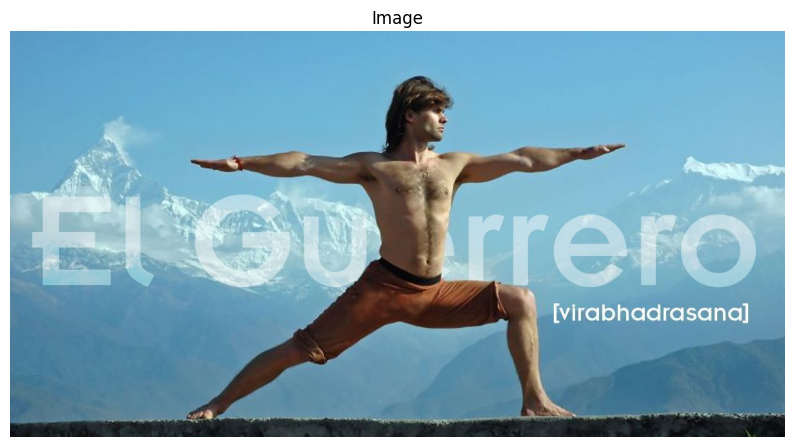

In [11]:
path = valid_folder

for img in os.listdir(path):

    image_path = path + '/' + img

    image = cv2.imread(image_path)

    with mp_pose.Pose(
        static_image_mode=True,
        min_detection_confidence=0.5) as pose:

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        #Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        poses = results.pose_landmarks.landmark
        pose_row = list(np.array(
            [[landmark.x, landmark.y, landmark.z, landmark.visibility]
            for landmark in poses]).flatten())

        X = pd.DataFrame([pose_row], columns=landmarks)
        body_language_class = model.predict(X)[0]
        #body_language_class = idx_to_name[model.predict(X)[0]]

        print(f'File name: {img} - Predicction: {body_language_class}')
        plt.figure(figsize=[10,10])
        plt.title('Image'); plt.axis('off');plt.imshow(image[:,:,::-1]);plt.show()

## Matriz de confusión en set de prueba

### Confusion matrix in test set

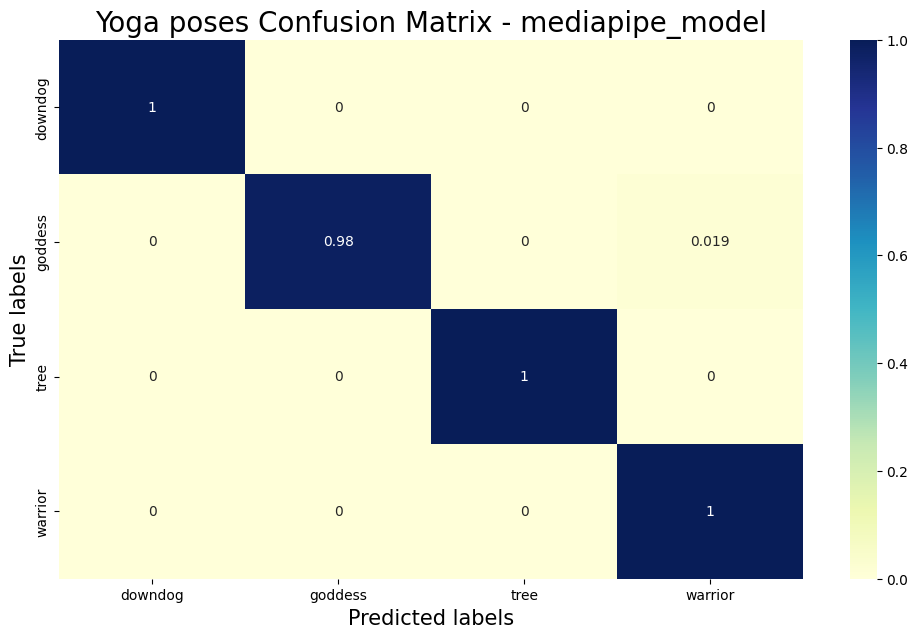

Accuracy : 99.55%


In [11]:
y_mediapipe = []
y_hat_mediapipe = []
file_name = []

model = fit_models['svm']

path = test_folder
for class_name in os.listdir(path):
    for image in os.listdir(path + '/' +  class_name):

        image_path = path + '/' + class_name + '/' + image

        image = cv2.imread(image_path)

        with mp_pose.Pose(static_image_mode=True,
                          min_detection_confidence=0.5) as pose:

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make Detections
            results = pose.process(image)

            #Recolor image back to BGR for rendering
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            poses = results.pose_landmarks.landmark
            pose_row = list(np.array(
                [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())

            X = pd.DataFrame([pose_row], columns=landmarks)
            body_language_class = model.predict(X)[0]
            #body_language_class = idx_to_name[model.predict(X)[0]]

        y_mediapipe.append(class_name)
        y_hat_mediapipe.append(body_language_class)
        file_name.append(image_path)

cf_matrix = confusion_matrix(y_mediapipe, y_hat_mediapipe)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in list(df_yoga_train['class'].unique())],
                     columns = [i for i in list(df_yoga_train['class'].unique())])

#df_cm.rename(columns = idx_to_name, index=idx_to_name, inplace = True)

plt.figure(figsize = (12,7))
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Yoga poses Confusion Matrix - mediapipe_model', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
plt.show()

print(f'Accuracy : {accuracy_score(y_mediapipe, y_hat_mediapipe):.2%}')

In [12]:
data = pd.DataFrame(list(zip(file_name, y_mediapipe, y_hat_mediapipe)),
                    columns = ['file_name', 'class', 'y_hat_mediapipe'])
data.head()

file_name    class y_hat_mediapipe
0  DATASET/TEST/downdog/00228.jpg  downdog         downdog
1  DATASET/TEST/downdog/00229.jpg  downdog         downdog
2  DATASET/TEST/downdog/00230.jpg  downdog         downdog
3  DATASET/TEST/downdog/00231.jpg  downdog         downdog
4  DATASET/TEST/downdog/00232.jpg  downdog         downdog

79, class: goddess , predicción: warrior


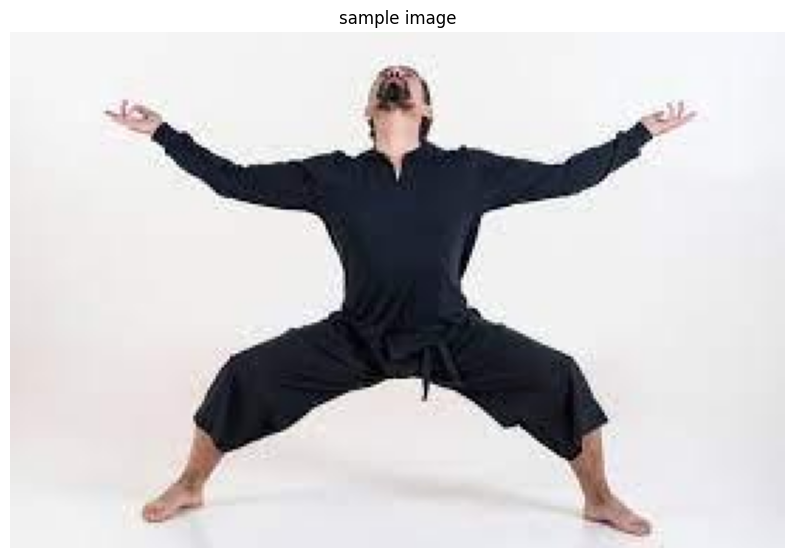

In [13]:
# Display the image that the model detected incorrectly
n=-1
for i, j in zip(data['class'], data['y_hat_mediapipe']):
  n += 1
  if i != j:
    print(f'{n}, class: {i} , predicción: {j}')
    sample_img = cv2.imread(data['file_name'][n])
    plt.figure(figsize=[10,10])
    plt.title('sample image'); plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## Optuna: Optimización de hiperparametros

Si bien el accuracy del modelo es muy alto se verifica con Optuna si se puede mejorar

Although the model's accuracy is very high, it is verified with Optuna if it can be improved

In [18]:
# Define the objective function for hyperparameter optimization
def objective(trial):
    """
    Objective function for optimizing hyperparameters of a RandomForestClassifier using Optuna.
    
    Args:
        trial: A `Trial` object from Optuna that contains the state of the optimization trial.
    
    Returns:
        The accuracy score of the RandomForestClassifier using the hyperparameters suggested by Optuna.
    """
    # Define the hyperparameters to optimize
    max_iter = trial.suggest_int('max_iter', 100, 500)
    penalty = trial.suggest_categorical("penalty", ['l1', 'l2'])
    tol = trial.suggest_float('tol', 1e-4, 1e-3)
    C  = trial.suggest_float("C", 0.5, 1)

    if penalty == 'l1':
        solver = trial.suggest_categorical("solver1", ['liblinear'])
    if penalty == 'l2':
        solver = trial.suggest_categorical("solver2", ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
        
    
    # Crear el clasificador con los hiperparámetros sugeridos por Optuna
    clf = LogisticRegression(
                                    max_iter=max_iter,
                                    penalty=penalty,
                                    tol=tol,
                                    C=C,
                                    solver=solver
                                    )
    
    # Entrenar el clasificador y calcular la precisión en el conjunto de prueba
    X_train_st = StandardScaler().fit_transform(X_train)
    X_test_st = StandardScaler().fit_transform(X_test)
    clf.fit(X_train_st, y_train)
    y_pred = clf.predict(X_test_st)
    score = accuracy_score(y_test, y_pred)

    return score

# Create the Optuna study and run the optimization

#sampler = optuna.samplers.RandomSampler(seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Print optimization results
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-01-01 20:48:34,169] A new study created in memory with name: no-name-7d2ea63f-d16f-4346-8462-ea6597a14fe0
[I 2024-01-01 20:48:34,226] Trial 0 finished with value: 0.9954954954954955 and parameters: {'max_iter': 250, 'penalty': 'l1', 'tol': 0.000638792635777333, 'C': 0.5780093202212182, 'solver1': 'liblinear'}. Best is trial 0 with value: 0.9954954954954955.
[I 2024-01-01 20:48:34,364] Trial 1 finished with value: 0.9954954954954955 and parameters: {'max_iter': 162, 'penalty': 'l2', 'tol': 0.000641003510568888, 'C': 0.8540362888980227, 'solver2': 'liblinear'}. Best is trial 0 with value: 0.9954954954954955.
[I 2024-01-01 20:48:34,445] Trial 2 finished with value: 0.9954954954954955 and parameters: {'max_iter': 222, 'penalty': 'l1', 'tol': 0.0003621062261782377, 'C': 0.8059264473611898, 'solver1': 'liblinear'}. Best is trial 0 with value: 0.9954954954954955.
c:\Users\juani\.virtualenvs\Yoga-Pose-Estimation---CEIA-BKShoW6E\Lib\site-packages\sklearn\linear_model\_sag.py:350: Conver

Best trial: score 1.0, params {'max_iter': 155, 'penalty': 'l2', 'tol': 0.0005104629857953323, 'C': 0.8925879806965068, 'solver2': 'sag'}


Se ve que es posible encontrar una combinación de hiperparametros que disminuya el número de iteraciones para converger.

it is possible to find a combination of hyperparameters that reduces the number of iterations to converge.

In [66]:
# Define the objective function for hyperparameter optimization
def objective(trial):
    """
    Objective function for optimizing hyperparameters of a RandomForestClassifier using Optuna.
    
    Args:
        trial: A `Trial` object from Optuna that contains the state of the optimization trial.
    
    Returns:
        The accuracy score of the RandomForestClassifier using the hyperparameters suggested by Optuna.
    """
    # Define the hyperparameters to optimize
    kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    tol = trial.suggest_float('tol', 1e-4, 1e-3)
    C  = trial.suggest_float("C", 0.5, 1)
    decision_function_shape = trial.suggest_categorical('suggest_categorical', ['ovo','ovr'])

    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 4)
        clf = svm.SVC(probability=True,
            kernel=kernel,
            tol=tol,
            C=C,
            decision_function_shape=decision_function_shape,
            degree = degree
                                )
    # if penalty == 'l2':
    #     solver = trial.suggest_categorical("solver2", ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
        
    
    # Crear el clasificador con los hiperparámetros sugeridos por Optuna
    clf = svm.SVC(probability=True,
                kernel=kernel,
                tol=tol,
                C=C,
                decision_function_shape=decision_function_shape)
    
    # Entrenar el clasificador y calcular la precisión en el conjunto de prueba
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return score

# Create the Optuna study and run the optimization

#sampler = optuna.samplers.RandomSampler(seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Print optimization results
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2024-01-27 19:33:57,484] A new study created in memory with name: no-name-2f89f897-014c-41e2-b17f-f8e85689dec7
[I 2024-01-27 19:33:57,571] Trial 0 finished with value: 0.9954954954954955 and parameters: {'kernel': 'poly', 'tol': 0.00024041677639819288, 'C': 0.5779972601681014, 'suggest_categorical': 'ovr', 'degree': 3}. Best is trial 0 with value: 0.9954954954954955.
[I 2024-01-27 19:33:57,764] Trial 1 finished with value: 0.9774774774774775 and parameters: {'kernel': 'rbf', 'tol': 0.00029110519961044856, 'C': 0.5909124836035503, 'suggest_categorical': 'ovr'}. Best is trial 0 with value: 0.9954954954954955.
[I 2024-01-27 19:33:58,193] Trial 2 finished with value: 0.6666666666666666 and parameters: {'kernel': 'sigmoid', 'tol': 0.00022554447458683765, 'C': 0.6460723242676091, 'suggest_categorical': 'ovr'}. Best is trial 0 with value: 0.9954954954954955.
[I 2024-01-27 19:33:58,246] Trial 3 finished with value: 0.9954954954954955 and parameters: {'kernel': 'linear', 'tol': 0.00014180537

Best trial: score 0.9954954954954955, params {'kernel': 'poly', 'tol': 0.00024041677639819288, 'C': 0.5779972601681014, 'suggest_categorical': 'ovr', 'degree': 3}


# Validación de modelos por video anotado
#### Estimación de posturas en video

# Model validation by annotated video
### Performing posture estimation on video

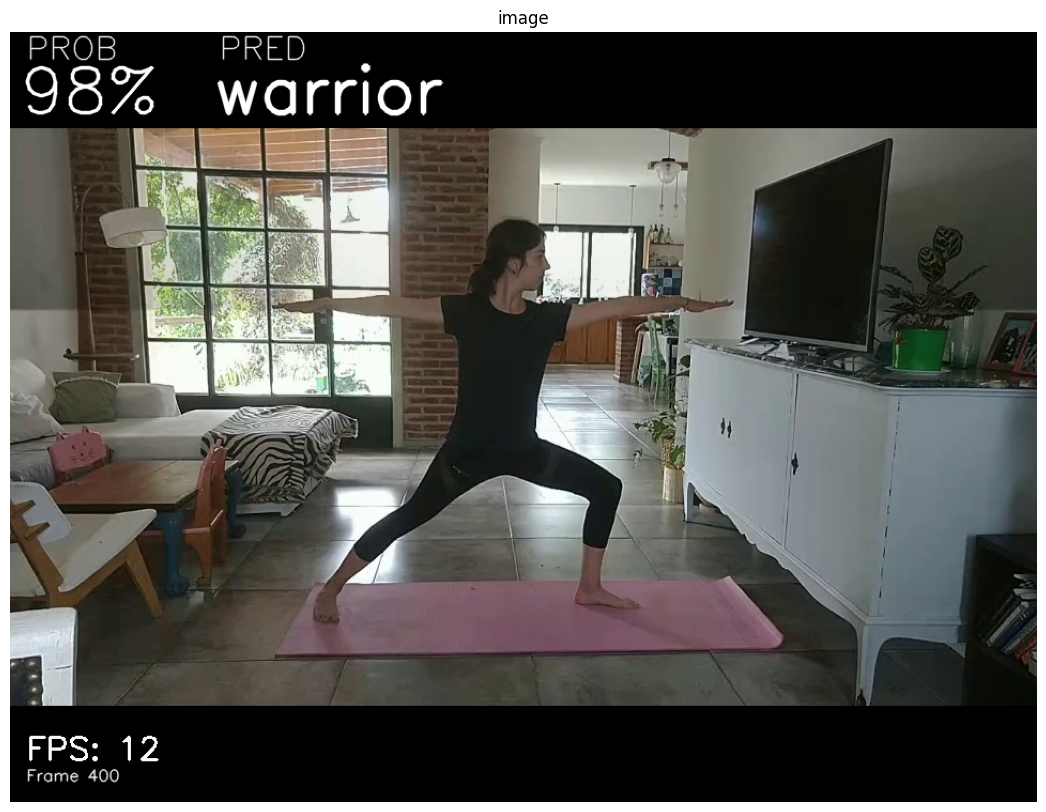

In [13]:
mp_pose = mp.solutions.pose  # Mediapipe Solutions
cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')

model = fit_models['lrcv']

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter('Video//out_video_mp.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (width, height), True)

start_time = time.time()
prev_frame_time = 0
pred_frame = []
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            pass
        if frame is None:
            break

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
        
        # Predicción del Frame
        poses = results.pose_landmarks.landmark
        row = list(np.array(
            [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())
        X = pd.DataFrame([row], columns=landmarks)
        body_language_class = model.predict(X)[0]
        body_language_prob = model.predict_proba(X)[0]
            
        proba = body_language_prob[np.argmax(body_language_prob)]
        prediction = body_language_class
    
        # if  proba < 0.79:
        #     prediction = "no_pose"

        # Mido FPS
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        new_frame_time = time.time()
        fps = int(1/(new_frame_time-prev_frame_time))
        prev_frame_time = new_frame_time

        pred_frame.append(prediction)

        # Generar imagen final con agregado de la imformación

        cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, str(prediction), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 3, cv2.LINE_AA)
        cv2.putText(image, f'{proba:.0%}',(10, 75), 
                    cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (250, 250, 250),2)

        # Guardar el video generado
        result.write(image)

        # Definir la imagen para imprimir
        print_frame = 400
        if current_frame == print_frame:
            print_image = image
        elif current_frame < print_frame:
            print_image = image

        cv2.imshow('Video', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
result.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()

Se carga el archivo que tiene la anotación de la postura de cada frame del video de muestra para la validación de los modelos

In [13]:
# Carga de archivo
annotated_video = pd.read_csv("Video\\annotated_video_sample.csv")

In [31]:
# Calculo de accuracy
accuracy_score(annotated_video['annotated_pose'], pred_frame)

0.807897545357524

In [ ]:
mp_pose = mp.solutions.pose  # Mediapipe Solutions

pred_frame_model = {}
fps_model = {}

for m in list(fit_models.keys()):

    model = fit_models[m]

    cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    start_time = time.time()
    prev_frame_time = 0
    pred_frame = []
    fps_list = []
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()

            if not success:
                pass
            if frame is None:
                break

            # Recolor Feed
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make Detections
            results = pose.process(image)

            # Recolor image back to BGR for rendering
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
            
            # Predicción del Frame
            poses = results.pose_landmarks.landmark
            row = list(np.array(
                [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                    for landmark in poses]).flatten())
            X = pd.DataFrame([row], columns=landmarks)
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
                
            proba = body_language_prob[np.argmax(body_language_prob)]
            prediction = body_language_class
        
            # if  proba < 0.79:
            #     prediction = "no_pose"

            # Mido FPS
            current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            new_frame_time = time.time()
            fps = int(1/(new_frame_time-prev_frame_time))
            prev_frame_time = new_frame_time

            pred_frame.append(prediction)
            fps_list.append(fps)

            # Generar imagen final con agregado de la imformación

            cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                        1, cv2.LINE_AA)
            cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                        1, cv2.LINE_AA)
            cv2.putText(image, str(prediction), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (255, 255, 255), 3, cv2.LINE_AA)
            cv2.putText(image, f'{proba:.0%}',(10, 75), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (250, 250, 250),2)
            cv2.putText(image, f'model: {m}', (700, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (250, 250, 250),2)


            cv2.imshow('Video', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

    pred_frame_model[m] = pred_frame
    fps_model[m] = fps_list


### Calculo de accuracy en cada modelo

In [22]:
for k,v in pred_frame_model.items():
    accur = accuracy_score(annotated_video['annotated_pose'], v)
    print(f'Acc {k}: {accur:.2%}')

Acc lr: 80.79%
Acc lrcv: 80.79%
Acc rf: 80.68%
Acc svm: 80.68%


### Calculo de FPS para cada modelo

In [23]:
for mo, f in fps_model.items():
    avg_fps_model = sum(f)/len(f)
    print(f'Avg FPS model {mo}: {round(avg_fps_model,2)}')

Avg FPS model lr: 15.07
Avg FPS model lrcv: 15.22
Avg FPS model rf: 12.45
Avg FPS model svm: 14.62


### Verificaion de diferentes limites de probabilidad de postura correcta 

De 70% a 95%

In [36]:
mp_pose = mp.solutions.pose  # Mediapipe Solutions

pred_frame_model = {}
fps_model = {}

for m in list(fit_models.keys())[:4]:

    pred_frame_model_p = {}
    fps_list = []

    for p in range(70,95,2):

        model = fit_models[m]

        cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        start_time = time.time()
        prev_frame_time = 0
        pred_frame = []
        
        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                success, frame = cap.read()

                if not success:
                    pass
                if frame is None:
                    break

                # Recolor Feed
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                # Make Detections
                results = pose.process(image)

                # Recolor image back to BGR for rendering
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
                
                # Predicción del Frame
                poses = results.pose_landmarks.landmark
                row = list(np.array(
                    [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                        for landmark in poses]).flatten())
                X = pd.DataFrame([row], columns=landmarks)
                body_language_class = model.predict(X)[0]
                body_language_prob = model.predict_proba(X)[0]
                    
                proba = body_language_prob[np.argmax(body_language_prob)]
                prediction = body_language_class
            
                if  proba < (p/100):
                    prediction = "no_pose"

                # Mido FPS
                current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
                new_frame_time = time.time()
                fps = int(1/(new_frame_time-prev_frame_time))
                prev_frame_time = new_frame_time

                pred_frame.append(prediction)
                fps_list.append(fps)

                # Generar imagen final con agregado de la imformación

                cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                            1, cv2.LINE_AA)
                cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                            1, cv2.LINE_AA)
                cv2.putText(image, str(prediction), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                            (255, 255, 255), 3, cv2.LINE_AA)
                cv2.putText(image, f'{proba:.0%}',(10, 75), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2,
                            (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (250, 250, 250),2)
                cv2.putText(image, f'model: {m}', (700, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (250, 250, 250),2)
                cv2.putText(image, f'p: {p}', (700, height-10), cv2.FONT_HERSHEY_SIMPLEX, 1,
                            (250, 250, 250),1)


                cv2.imshow('Video', image)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

        cap.release()
        cv2.destroyAllWindows()

        pred_frame_model_p[p] = pred_frame

    pred_frame_model[m] = pred_frame_model_p
    fps_model[m] = fps_list

### Guardado de los datos de validación

In [37]:
with open('data_validacion/pred_frame_model.json', 'w') as fp:
    json.dump(pred_frame_model, fp)

with open('data_validacion/fps_model.json', 'w') as fp:
    json.dump(fps_model, fp)

In [4]:
# Cargar los datos de validación
with open('data_validacion/pred_frame_model.json') as f:
    pred_frame_model = json.load(f)

with open('data_validacion/fps_model.json') as f:
    fps_model = json.load(f)

Model: lr 
Acc p=70%: 85.59%
Acc p=72%: 86.02%
Acc p=74%: 86.13%
Acc p=76%: 86.66%
Acc p=78%: 86.77%
Acc p=80%: 87.41%
Acc p=82%: 87.83%
Acc p=84%: 88.58%
Acc p=86%: 89.22%
Acc p=88%: 89.65%
Acc p=90%: 89.65%
Acc p=92%: 87.73%
Acc p=94%: 82.60%

Model: lrcv 
Acc p=70%: 85.91%
Acc p=72%: 86.45%
Acc p=74%: 86.87%
Acc p=76%: 87.19%
Acc p=78%: 88.05%
Acc p=80%: 88.15%
Acc p=82%: 87.30%
Acc p=84%: 86.55%
Acc p=86%: 83.24%
Acc p=88%: 77.27%
Acc p=90%: 76.63%
Acc p=92%: 76.84%
Acc p=94%: 77.05%

Model: rf 
Acc p=70%: 88.26%
Acc p=72%: 88.47%
Acc p=74%: 89.22%
Acc p=76%: 90.07%
Acc p=78%: 89.65%
Acc p=80%: 89.22%
Acc p=82%: 88.69%
Acc p=84%: 88.37%
Acc p=86%: 86.13%
Acc p=88%: 79.51%
Acc p=90%: 73.96%
Acc p=92%: 66.92%
Acc p=94%: 60.51%

Model: svm 
Acc p=70%: 90.93%
Acc p=72%: 91.46%
Acc p=74%: 91.89%
Acc p=76%: 92.74%
Acc p=78%: 91.25%
Acc p=80%: 90.18%
Acc p=82%: 89.65%
Acc p=84%: 88.58%
Acc p=86%: 86.55%
Acc p=88%: 79.08%
Acc p=90%: 76.63%
Acc p=92%: 75.67%
Acc p=94%: 74.60%



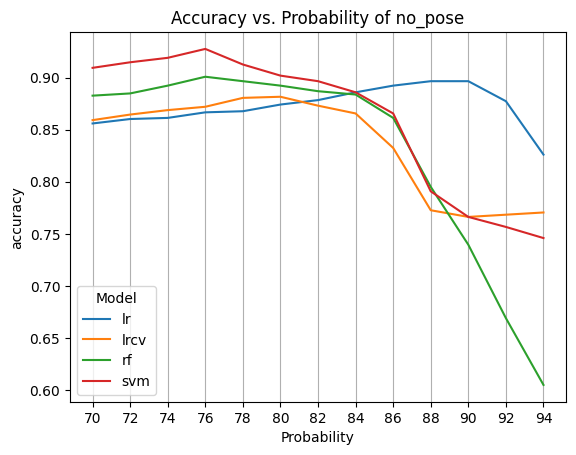

In [25]:
accu_mo = {}
for mod in pred_frame_model.keys():
    print(f'Model: {mod} ')
    accu = {}
    for k,v in pred_frame_model[mod].items():
        accur = accuracy_score(annotated_video['annotated_pose'], v)
        accu[k] = accur
        print(f'Acc p={k}%: {accur:.2%}')
    print()
    accu_mo[mod] = accu
    plt.plot(accu_mo[mod].keys(), accu_mo[mod].values())
plt.legend(accu_mo.keys(),title="Model")
plt.xlabel("Probability")
plt.ylabel("accuracy")
plt.title("Accuracy vs. Probability of no_pose")
plt.xticks(list(accu.keys()))
plt.grid(axis= 'x')
plt.show()


In [45]:
#Calculo en que valor se da el accuracy maximo en cada modelo
max_prob_mo = {}
for m in accu_mo.keys():
    max_prob_mo[m] = list(accu_mo[m].keys())[list(accu_mo[m].values()).index(max(accu_mo[m].values()))]
max_prob_mo

{'lr': '88', 'lrcv': '80', 'rf': '76', 'svm': '76'}

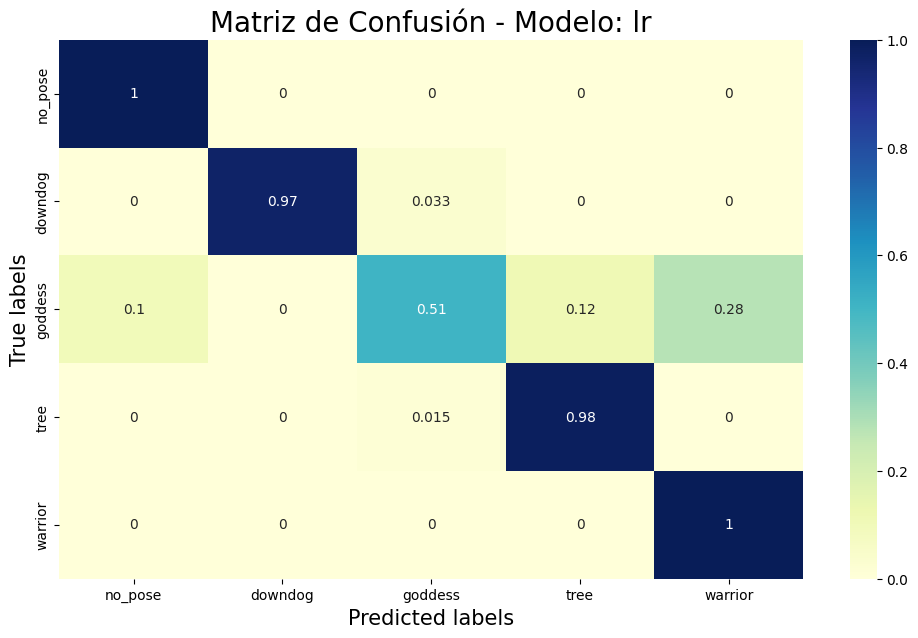

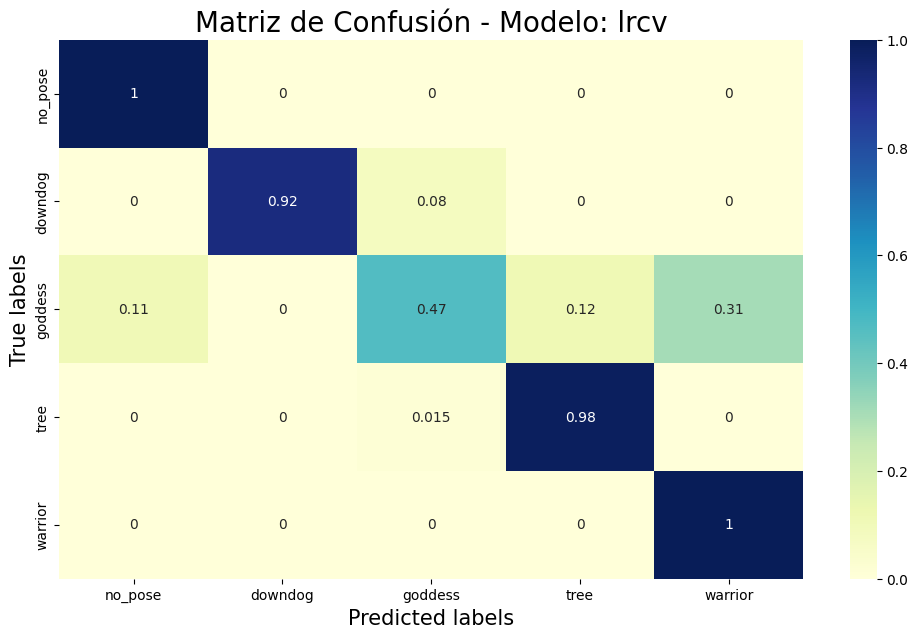

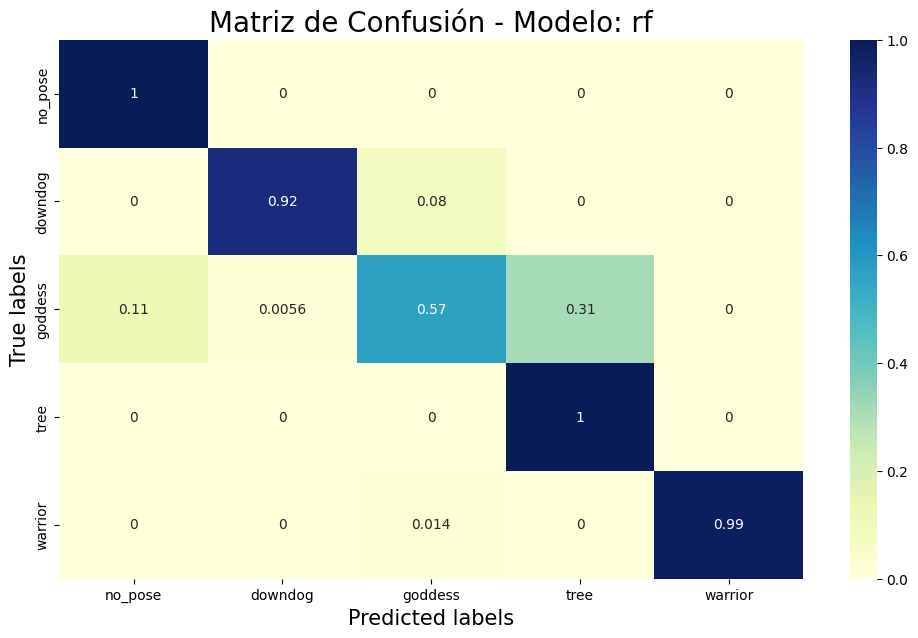

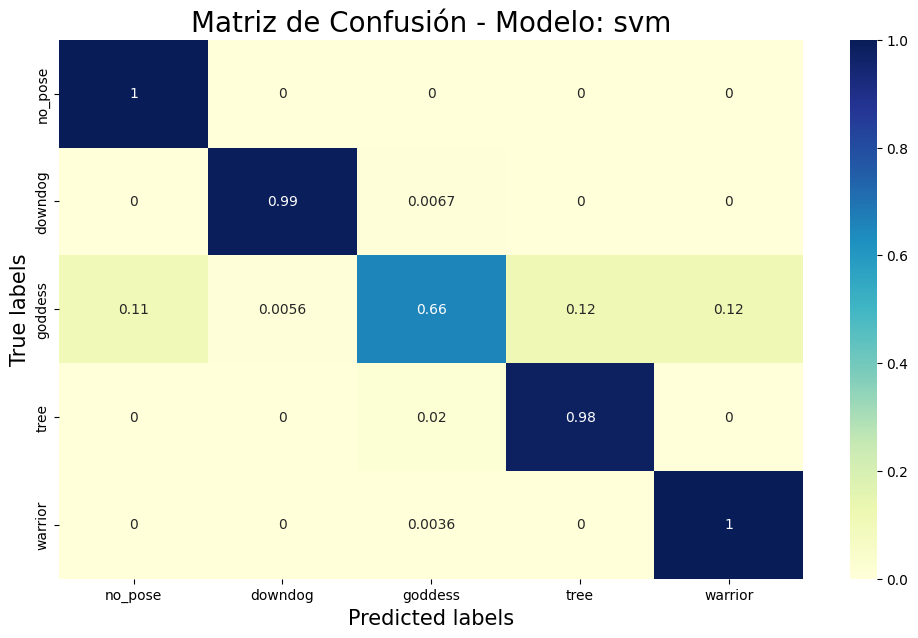

In [51]:
for m, p in zip(pred_frame_model.keys(), list(max_prob_mo.values())):
    cf_matrix = confusion_matrix(annotated_video['annotated_pose'], pred_frame_model[m][p])
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                        index = [i for i in ['no_pose','downdog', 'goddess', 'tree', 'warrior']],
                        columns = [i for i in ['no_pose','downdog', 'goddess', 'tree', 'warrior']])

    plt.figure(figsize = (12,7))
    ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
    plt.title(f'Matriz de Confusión - Modelo: {m}', fontsize = 20)
    plt.xlabel('Predicted labels', fontsize = 15)
    plt.ylabel('True labels', fontsize = 15)
    plt.show()

#### Verificación de FPS para cada modelo

In [39]:
for mo, f in fps_model.items():
    avg_fps_model = sum(f)/len(f)
    print(f'Avg FPS model {mo}: {round(avg_fps_model,2)}')

Avg FPS model lr: 14.61
Avg FPS model lrcv: 14.64
Avg FPS model rf: 12.56
Avg FPS model svm: 14.62


### Optencion de tiempo optimo de espera para el modelo SVM

In [29]:
mp_pose = mp.solutions.pose  # Mediapipe Solutions

annotated_video = pd.read_csv("Video\\annotated_video_sample.csv")

fps_pred_time = {}
acuracy_time ={}

model = fit_models['svm']

for t in [0, 0.5, 1, 2]:

    cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    prediction = "no_pose"
    start_time = time.time()
    prev_frame_time = 0
    pred_frame = []
    fps_list = []
    num_pred = 0

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            success, frame = cap.read()

            if not success:
                pass
            if frame is None:
                break

            # Recolor Feed
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make Detections
            results = pose.process(image)

            # Recolor image back to BGR for rendering
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Predicción del Frame
            poses = results.pose_landmarks.landmark
            row = list(np.array(
                [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                    for landmark in poses]).flatten())

            # Make Detections every "t" seconds

            current_time = round(time.time()-start_time,2)
 
            if t == 0 :
                refresh_time = 0
            else:
                refresh_time = round(current_time % t,1)

            if (prediction == "no_pose") or (refresh_time == 0):
                X = pd.DataFrame([row], columns=landmarks)
                body_language_class = model.predict(X)[0]
                body_language_prob = model.predict_proba(X)[0]
                num_pred += 1
                
            proba = body_language_prob[np.argmax(body_language_prob)]
            prediction = body_language_class
            body_language = body_language_class
        
            if  proba < 0.76:
                prediction = "no_pose"

            # Mido FPS
            current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
            new_frame_time = time.time()
            fps = int(1/(new_frame_time-prev_frame_time))
            prev_frame_time = new_frame_time

            pred_frame.append(prediction)
            
            fps_list.append([current_frame, fps])

            # Generar imagen final con agregado de la imformación

            cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                        1, cv2.LINE_AA)
            cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                        1, cv2.LINE_AA)
            cv2.putText(image, str(prediction), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (255, 255, 255), 3, cv2.LINE_AA)
            cv2.putText(image, f'{proba:.0%}',(10, 75), 
                        cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                        (250, 250, 250),2)
            
            cv2.putText(image, f'time: {current_time}', (500, height-60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            cv2.putText(image, f' refresh time: {refresh_time}', (500, height-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            cv2.putText(image, f'num pred: {num_pred}', (700, height-60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

            cv2.putText(image, f't param: {t}', (700, height-20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)            

            cv2.imshow('Video', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    
    acuracy = accuracy_score(annotated_video['annotated_pose'], pred_frame)

    acuracy_time[t] = acuracy
    fps_pred_time[t] = fps_list


In [30]:
print("Promedio de FPS para lapsos de tiempos de detección")
for s in fps_pred_time.keys():
    avg = sum([fps_pred_time[s][fps][1] for fps in range(len(fps_pred_time[0]))])/len(fps_pred_time[0])

    print(f'- {s} seg: {round(avg,2)} FPS promedio')

Promedio de FPS para lapsos de tiempos de detección
- 0 seg: 15.12 FPS promedio
- 0.5 seg: 16.98 FPS promedio
- 1 seg: 17.19 FPS promedio
- 2 seg: 17.47 FPS promedio


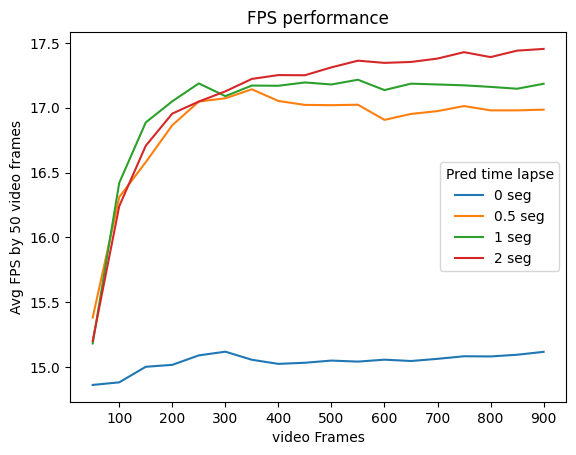

In [31]:
for s in fps_pred_time.keys():
    avg_list=[]
    for t in range(50,len(fps_pred_time[s]),50):
        t0 = 0
        rang = range(t0,t)
        avg = sum([fps_pred_time[s][fps][1] for fps in rang])/len(rang)
        avg_list.append(avg)
        t0 = t
    plt.plot(range(50,len(fps_pred_time[s]),50),avg_list)
plt.legend([str(f) + ' seg' for f in fps_pred_time.keys()],title="Pred time lapse")
plt.xticks(range(100,len(fps_pred_time[s]),100))
plt.xlabel("video Frames")
plt.ylabel("Avg FPS by 50 video frames")
plt.title("FPS performance")
plt.show()

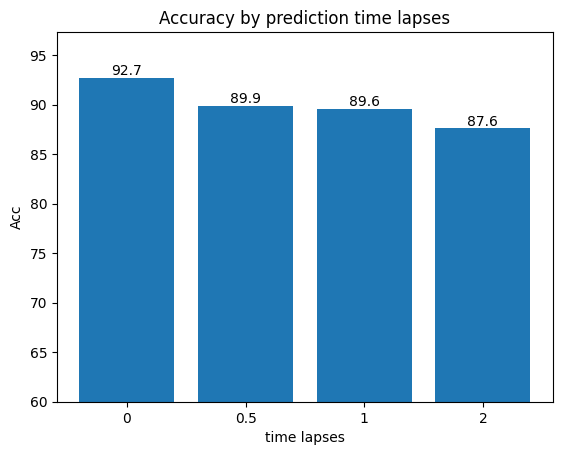

In [32]:
fig, ax = plt.subplots()

p = ax.bar([str(k) for k in acuracy_time.keys()], [round(a*100,1) for a in acuracy_time.values()])
ax.bar_label(p, label_type='edge')
ax.set_ylim(60)
ax.set_title("Accuracy by prediction time lapses")
ax.set_ylabel("Acc")
ax.set_xlabel("time lapses")

plt.show()

# Interfaz

## Interface

Código para la estimación  por video con los indicadores en pantalla para la corrección de postura.

Code for video estimation with on-screen indicators for posture correction.

In [10]:
# Definition of necessary functions

def inFrame(lst):
    '''
    Check if specific landmarks in a list of facial landmarks are visible.

    This function checks the visibility confidence of specific body landmarks (landmark indices
    15, 16, 27, and 28) and returns True if at least one of the landmarks on each side of the face
    is visible with a confidence greater than 0.6.

    Parameters:
        lst (list): A list containing facial landmarks, where each landmark is represented as an
                    object with attributes like 'visibility'.

    Returns:
        bool: True if at least one landmark on each side of the face is visible with confidence
              greater than 0.6, False otherwise.
    '''
    if ((lst[28].visibility > 0.6 or lst[27].visibility > 0.6)
            and (lst[2].visibility > 0.6 or lst[5].visibility > 0.6)):
        return True
    return False

def calculate_angle_coord(p_cood_list):
    """
    Calculate the angle formed by three coordinates in a 2D plane.

    Parameters:
        p_cood_list (list): A list containing three 2D coordinate points as numpy arrays.

    Returns:
        float: The angle in degrees between the lines connecting the first and second points
               and the second and third points. The angle is always in the range [0, 180].
    
    first_point = p_cood_list[0][*]
    mid_point = p_cood_list[1][*]
    last_point = p_cood_list[2][*]
    """
    radians = math.atan2(p_cood_list[2][1]-p_cood_list[1][1], p_cood_list[2][0]-p_cood_list[1][0]) - \
        math.atan2(p_cood_list[0][1]-p_cood_list[1][1], p_cood_list[0][0]-p_cood_list[1][0])
    angle = abs(radians*180.0/math.pi)

    if angle > 180.0:
        angle = 360-angle

    return angle

In [11]:
# variables definition

landmarks = []
for val in range(0, 33):
    landmarks += ['x{}'.format(val), 
                  'y{}'.format(val),
                  'z{}'.format(val), 
                  'v{}'.format(val)]


# Define the angles to messure
# The angles were obtained with the data analysis of each posture
# Define the angles to messure
dic = {'downdog': {(23, 11, 13): 169,
                   (24, 12, 14): 169,
                   (11, 13, 15): 166,
                   (12, 14, 16): 166,
                   (11, 23, 25): 56,
                   (12, 24, 26): 56,
                   (23, 25, 27): 174,
                   (24, 26, 28): 174,},
        'goddess': {(11, 23, 25): 108,
                    (12, 24, 26): 108, 
                    (23, 25, 27): 114, 
                    (24, 26, 28): 114,},
        'tree': {(11, 23, 25): 120,
                (12, 24, 26): 174, 
                (23, 25, 27): 56,
                (24, 26, 28): 176},
        'tree_inv': {(11, 23, 25): 174,
                    (12, 24, 26): 120, 
                    (23, 25, 27): 176,
                    (24, 26, 28): 56},
        'warrior': {(13, 11, 23): 95,
                    (14, 12, 24): 97,
                    (11, 13, 15): 172,
                    (16, 14, 12): 171,
                    (11, 23, 25): 100,
                    (12, 24, 26): 135,
                    (23, 25, 27): 110,
                    (24, 26, 28): 170},
        'warrior_inv': {(13, 11, 23): 95,
                        (14, 12, 24): 97,
                        (11, 13, 15): 172,
                        (16, 14, 12): 171,
                        (11, 23, 25): 135,
                        (12, 24, 26): 100,
                        (23, 25, 27): 170,
                        (24, 26, 28): 110}
        }

# Images to display on screen
dic_images = {'downdog': 'interface/pages/Data/images_display/video/downdog.png',
                'warrior': 'interface/pages/Data/images_display/video/warrior.png',
                'warrior_inv': 'interface/pages/Data/images_display/video/warrior_inv.png',
                'goddess': 'interface/pages/Data/images_display/video/goddess.png',
                'tree': 'interface/pages/Data/images_display/video/Tree.png',
                'tree_inv': 'interface/pages/Data/images_display/video/tree_inv.png'
                }

mp_pose = mp.solutions.pose  # Mediapipe Solutions
mp_drawing = mp.solutions.drawing_utils  # Drawing helpers

### Principal
### Main

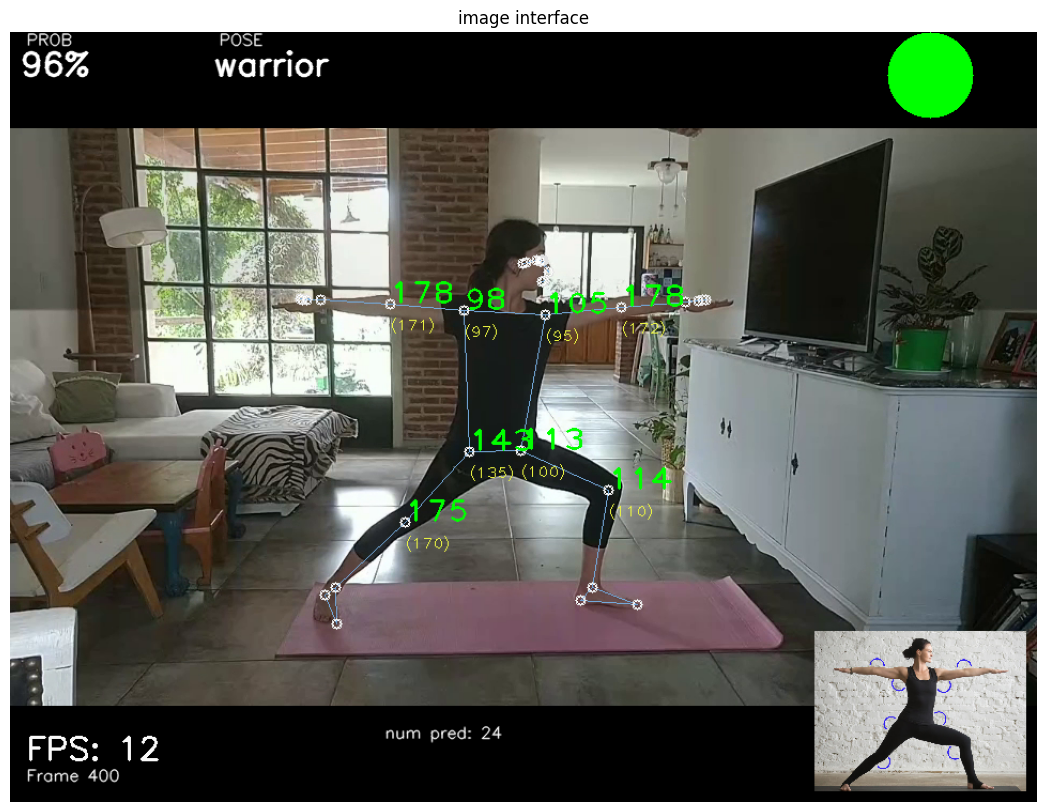

In [14]:
cap = cv2.VideoCapture('interface/pages/Data//sample_video.mp4')

frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

model = fit_models['svm']

result = cv2.VideoWriter('Video//out_video_interface.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (frame_width, frame_height), True)

# start variables
body_language = 0
body_language_time = 0
pose_time = 0
report = []
report_time = []
prev_frame_time = 0
new_frame_time = 0
num_pred = 0
start_time = time.time()

with mp_pose.Pose(model_complexity=1, 
                    smooth_landmarks = True, 
                    min_detection_confidence=0.5, 
                    min_tracking_confidence=0.5) as pose:

    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            break
        if frame is None:
            break

        # Mido FPS
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        new_frame_time = time.time()
        fps = 1/(new_frame_time-prev_frame_time)
        prev_frame_time = new_frame_time    
        fps = int(fps)

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Export coordinates
        try:
            circle_coord = ((frame_width-100), 40)

            if results.pose_landmarks and inFrame(results.pose_landmarks.landmark):

                # Draw the landmarks connections
                mp_drawing.draw_landmarks(image, results.pose_landmarks,
                                            mp_pose.POSE_CONNECTIONS,
                                            mp_drawing.DrawingSpec(color=(255, 255, 255),
                                                                    thickness=1,
                                                                    circle_radius=4),
                                            mp_drawing.DrawingSpec(color=(219, 170, 117),
                                                                    thickness=1,
                                                                    circle_radius=2)
                                            )

                # Extract Pose landmarks
                poses = results.pose_landmarks.landmark
                row = list(np.array(
                    [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                        for landmark in poses]).flatten())

                # Make Detections every 'time_laps' seconds
                time_laps = 1
                current_time = round(time.time()-start_time,2)
                refresh_time = round(current_time % time_laps,1)

                if (body_language == 0) or (refresh_time == 0):
                    X = pd.DataFrame([row], columns=landmarks)
                    body_language_class = model.predict(X)[0]
                    body_language_prob = model.predict_proba(X)[0]
                    num_pred += 1


                if body_language_prob[np.argmax(body_language_prob)] < 0.50:
                    body_language = 0

                # Draw the status box
                cv2.rectangle(image,
                                (0, 0),
                                (600, 60),
                                (0, 0, 0),
                                -1)

                # Display pose detected
                cv2.putText(image,
                            'POSE',
                            (195, 12),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (250, 250, 250),
                            1,
                            cv2.LINE_AA)
                
                cv2.putText(image,
                            'PROB',
                            (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            0.5,
                            (250, 250, 250),
                            1,
                            cv2.LINE_AA)
                cv2.putText(image, f'num pred: {num_pred}', (350, height-60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)

                # Check if the pose detection probability is greater than 77%
                if body_language_prob[np.argmax(body_language_prob)] >= 0.76:
                    
                    body_language = body_language_class

                    cv2.putText(image,
                                body_language_class.split(' ')[0],
                                (190, 40),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA)
                    cv2.circle(image, 
                                circle_coord, 
                                40, 
                                (0, 255, 0), 
                                -1)
                    
                    # Display Probability

                    cv2.putText(image,
                                f'{body_language_prob[np.argmax(body_language_prob)]:.0%}',
                                (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA)
                
                else:
                    body_language = "no_pose"

                    cv2.putText(image,
                                "No pose",
                                (190, 40),
                                cv2.FONT_HERSHEY_SIMPLEX,
                                1,
                                (255, 255, 255),
                                2,
                                cv2.LINE_AA)
                    
                    cv2.circle(image,
                                circle_coord,
                                40,
                                (0, 0, 255),
                                -1)



                if body_language:
                    # The poses 'warrior' and 'tree' are not symmetrical. The next lines check  
                    # the angle in P26 to check whether the pose detected is rigth or left
                    # and select the angles to measure in correspondence.
                    dato_pose = body_language_class
                    if body_language_class in ['warrior', 'tree']:
                        angle_1 = 0
                        try:
                            angle_1 = int(calculate_angle_coord([(
                                results.pose_landmarks.landmark[24].x,
                                results.pose_landmarks.landmark[24].y),
                                (
                                results.pose_landmarks.landmark[26].x,
                                results.pose_landmarks.landmark[26].y),
                                (
                                results.pose_landmarks.landmark[28].x,
                                results.pose_landmarks.landmark[28].y)]))
                            
                            if angle_1 in range(1,150):
                                class_inv = body_language_class + '_inv'
                                p_dic = dic.get(class_inv)
                                dato_pose = class_inv
                            else:
                                p_dic = dic.get(body_language_class)

                        except:
                            pass

                        # if angle_1 in range(1,150):
                        #     class_inv = body_language_class + '_inv'
                        #     p_dic = dic.get(class_inv)
                        #     dato_pose = class_inv
                        # else:
                        #     p_dic = dic.get(body_language_class)

                    else:
                        p_dic = dic.get(body_language_class)
                    
                    
                    q_ang = 0 # inicilice the counting of the angles measured
                    q_ang_ok = 0 # inicilice the counting of the angles measured ok

                    # Extract the angles points to measure from angle dict.
                    for i in range(len(p_dic)):
                        p_cood_list = []
                        midle_point = list(p_dic.keys())[i][1]
                        for p in list(p_dic.keys())[i]:
                            if results.pose_landmarks.landmark[p].visibility > 0.5:
                                
                                p_corrd = (
                                    results.pose_landmarks.landmark[p].x,
                                    results.pose_landmarks.landmark[p].y)
                                p_cood_list.append(p_corrd)
                            else:
                                break

                        try:
                            # Meassure the angles
                            angle = int(calculate_angle_coord(p_cood_list))
                            angle_ok = int(list(p_dic.values())[i])
                            q_ang += 1
                            report.append([dato_pose,
                                            list(p_dic.keys())[i],
                                            angle_ok,
                                            angle])

                            # Print the angles into the image. Green if it is between the 
                            # tolerance and red if it is not.
                            tolerance = 15
                            if angle in range(angle_ok-tolerance, angle_ok+tolerance):
                                q_ang_ok += 1
                                text_color = (0, 255, 0)
                            else:
                                text_color = (0, 0, 255)

                            cv2.putText(image,
                                        str(angle),
                                        (int((results.pose_landmarks.landmark[midle_point].x) \
                                                *image.shape[1]),
                                            int((results.pose_landmarks.landmark[midle_point].y) \
                                                *image.shape[0])),
                                        cv2.FONT_HERSHEY_PLAIN,
                                        2,
                                        text_color,
                                        2)
                            cv2.putText(image,
                                        f'({angle_ok})',
                                        (int((results.pose_landmarks.landmark[midle_point].x) \
                                                *image.shape[1]),
                                            int((results.pose_landmarks.landmark[midle_point].y) \
                                                *image.shape[0])+25),
                                        cv2.FONT_HERSHEY_PLAIN,
                                        1,
                                        (66, 245, 236),
                                        1)

                        except:
                            pass

                    # Insert the example picture into the image
                    img_path = dic_images.get(dato_pose)
                    img = cv2.imread(img_path)
                    h = img.shape[0]
                    w = img.shape[1]
                    image[image.shape[0]-(h+10):image.shape[0]-10,
                            image.shape[1]-(w+10):image.shape[1]-10] = img
                    
                    # if any angle is out of range a red led turns on
                    if q_ang_ok != q_ang:
                        cv2.circle(image,
                            circle_coord,
                            20,
                            (0, 0, 250),
                            -1)

            # Print if the body is not fully visible                    
            else:
                cv2.putText(image,
                            "Make your Full",
                            (50, 35),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (66, 245, 236),
                            3)
                cv2.putText(image,
                            "body visible",
                            (50, 65),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            1,
                            (66, 245, 236),
                            3)
                cv2.circle(image,
                            circle_coord,
                            40,
                            (0, 0, 255),
                            -1)

        except:
            pass
        
        cv2.putText(image, f'Frame {current_frame}', (15, frame_height-20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f'FPS: {str(fps)}', (15, frame_height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (250, 250, 250),2)
        
        result.write(image)    

        # Definir la imagen para imprimir
        print_frame = 400
        if current_frame == print_frame:
            print_image = image
        elif current_frame < print_frame:
            print_image = image   

        cv2.imshow('Video interface', image)  

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

result.release()            
cap.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image interface'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()

# Informe final

Devuelve el valor de angulo optimo, el valor medio de las mediciones y el mejor logrado de cada punto en cada postura.

In [15]:
# Calculate the diference between the optimal angle and the mean angle)
angle_mesure = pd.DataFrame(report, columns=['pose',
                                                'punto',
                                                'ang optimo',
                                                'ang medido medio'])
angle_mesure.sort_values(by=['pose'])
angle_mesure['dif'] = abs(
    angle_mesure['ang optimo']-angle_mesure['ang medido medio'])
# Add column 'mejor' where is going to be the best angle reached
angle_mesure['mejor'] = 0
reporte_final = pd.DataFrame(columns=['pose',
                                        'punto',
                                        'ang optimo',
                                        'ang medido medio'])

# Calculate the best angle in relation with the reference angle for each yoga posture.
for j in angle_mesure['pose'].unique():
    informe = angle_mesure[angle_mesure['pose'] == j].copy()
    for i in informe['punto'].unique():
        minimo = informe[informe['punto'] == i]['dif'].min()
        best_ang = informe[(informe['punto'] == i) & (
            informe['dif'] == minimo)]['ang medido medio'][:1].item()
        informe.loc[informe['punto'] == i, 'mejor'] = best_ang
    informe = informe.drop(columns='dif')
    informe = informe.groupby(by=['pose', 'punto']
                                ).mean().astype(int).reset_index()
    reporte_final = pd.concat([reporte_final, informe], ignore_index=True)

reporte_final = reporte_final.astype({'ang optimo': 'int32',
                                        'ang medido medio': 'int32',
                                        'mejor': 'int32'})
for i in range(reporte_final.shape[0]):
    reporte_final.loc[reporte_final.index == i, 'punto'] = int(list(reporte_final['punto'][i])[1])
reporte_final = reporte_final.sort_values(by=['pose', 'punto'])
reporte_final

pose punto  ang optimo  ang medido medio  mejor
30      downdog    12         169               170    169
28      downdog    14         166               169    166
29      downdog    24          56                53     56
31      downdog    26         174               173    174
16      goddess    23         108               124    111
17      goddess    24         108               120    108
18      goddess    25         114               121    114
19      goddess    26         114               109    114
8          tree    23         120               131    120
9          tree    24         174               174    174
10         tree    25          56                78     52
11         tree    26         176               176    176
12     tree_inv    23         174               175    174
13     tree_inv    24         120               125    120
14     tree_inv    25         176               178    176
15     tree_inv    26          56                55     57
3       warrior    11          95                78     94
4       warrior    12          97                74     97
0       warrior    13         172               174    172
5       warrior    14         171               174    171
1       warrior    23         100               136    111
2       warrior    24         135               147    134
6       warrior    25         110               140    114
7       warrior    26         170               173    170
23  warrior_inv    11          95                94     95
24  warrior_inv    12          97               102     98
20  warrior_inv    13         172               161    172
25  warrior_inv    14         171               162    171
21  warrior_inv    23         135               138    136
22  warrior_inv    24         100               117    107
26  warrior_inv    25         170               162    173
27  warrior_inv    26         110               120    111

In [17]:
reporte_final.to_csv("data_validacion\\reporte_final.csv", sep=";")

### Se define la función 'report_images' para poder visualizar la información del reporte final en las imágenes de muestra de las posturas.

In [16]:
def report_images(report, poses):
    '''
    Print the angles of the yoga practice report into the example images to easily visualize the 
    results

    Parameters:
        report (pd.DataFrame): Yoga practice report.
        poses (list) : poses names to use

    Returns:
        Image with all the predetermined angle in the exact position so it can be easy to read.
    '''
    angle_coord_images = {
        'downdog': {
            11: [0.75, 0.55],
            12: [0.4, 0.73],
            13: [0.85, 0.73],
            14: [0.65, 0.91],
            23: [0.42, 0.28],
            24: [0.4, 0.35],
            25: [0.14, 0.45],
            26: [0.11, 0.6],
        },
        'warrior': {
            11: [0.7, 0.35],
            12: [0.2, 0.38],
            13: [0.7, 0.15],
            14: [0.25, 0.15],
            23: [0.76, 0.55],
            24: [0.2, 0.55],
            25: [0.75, 0.8],
            26: [0.15, 0.75],
        },
        'warrior_inv': {
            11: [0.7, 0.38],
            12: [0.2, 0.35],
            13: [0.7, 0.15],
            14: [0.25, 0.15],
            23: [0.72, 0.55],
            24: [0.2, 0.55],
            25: [0.75, 0.75],
            26: [0.15, 0.75],
        },
        'tree_inv': {
            23: [0.81, 0.5],
            24: [0.3, 0.45],
            25: [0.7, 0.72],
            26: [0.35, 0.72],
        },
        'tree': {
            23: [0.13, 0.50],
            24: [0.65, 0.45],
            25: [0.7, 0.72],
            26: [0.25, 0.72],
        },
        'goddess': {
            23: [0.77, 0.5],
            24: [0.23, 0.5],
            25: [0.81, 0.72],
            26: [0.20, 0.72],
        }
    }
    for pose in poses:

        path = 'interface/pages/Data/images_display/' + pose + '.png'
        image = cv2.imread(path)
        annotated_image = image.copy()
        df = report.loc[report['pose'].isin([pose])]

        incr_width = int(0.08*annotated_image.shape[1])

        for i in (sorted(df['punto'].unique())):

            ang_op = df['ang optimo'][df['punto'] == i].item()
            ang_med = df['ang medido medio'][df['punto'] == i].item()
            ang_best = df['mejor'][df['punto'] == i].item()

            tolerance = 15
            if ang_med in range(ang_op-tolerance, ang_op+tolerance):
                text_color = (0, 255, 0)
            else:
                text_color = (0, 0, 255)

            coord = (int(angle_coord_images[pose][i][0]*annotated_image.shape[1]),
                     int(angle_coord_images[pose][i][1]*annotated_image.shape[0]))

            cv2.rectangle(annotated_image, (int(coord[0]-incr_width*1.3), coord[1]-30),
                          (coord[0]-incr_width+260, coord[1]+10),
                          (100, 100, 100),
                          -1)
            cv2.putText(annotated_image, str(f'{i}'), (int(coord[0]-incr_width*1.2), coord[1]),
                        cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 1)
            cv2.putText(annotated_image, str(f'{ang_op}/'), (coord[0]-incr_width, coord[1]),
                        cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2) #(3, 152, 252)
            cv2.putText(annotated_image, str(f'{ang_med}/'), (coord[0], coord[1]),
                        cv2.FONT_HERSHEY_PLAIN, 2, text_color, 2)
            cv2.putText(annotated_image, str(ang_best), (coord[0]+incr_width, coord[1]),
                        cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)
            prev_i = i

        cv2.rectangle(annotated_image, (0, 0), (500, 40), (100, 100, 100),
                      -1)
        cv2.putText(annotated_image, 'Angulos:', (10, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
        cv2.putText(annotated_image, 'Optimo/', (150, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 2) #(3, 152, 252)
        cv2.putText(annotated_image, 'medio/', (290, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
        cv2.putText(annotated_image, 'mejor', (410, 30),
                    cv2.FONT_HERSHEY_PLAIN, 2, (255, 0, 0), 2)

        plt.title(f'inform image: {pose}'); plt.axis('off');plt.imshow(annotated_image[:,:,::-1])
        plt.show()

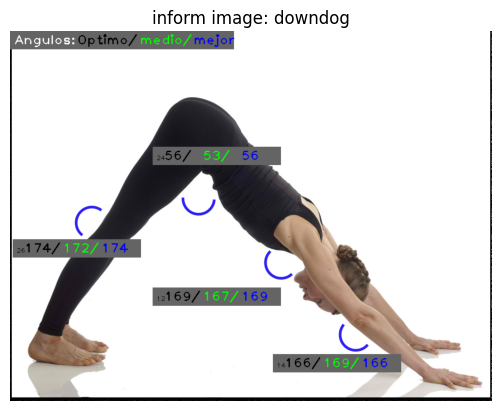

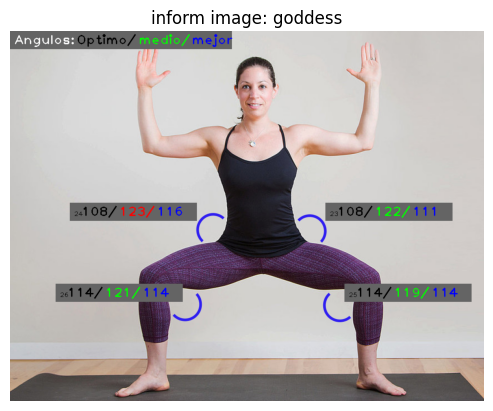

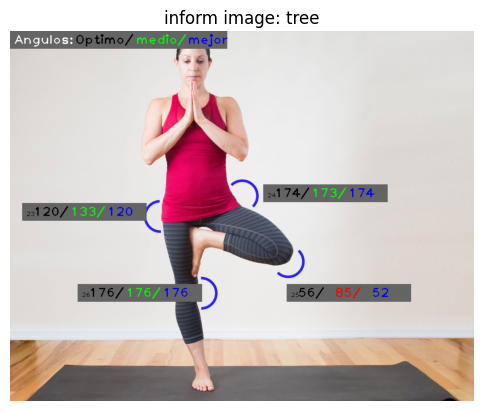

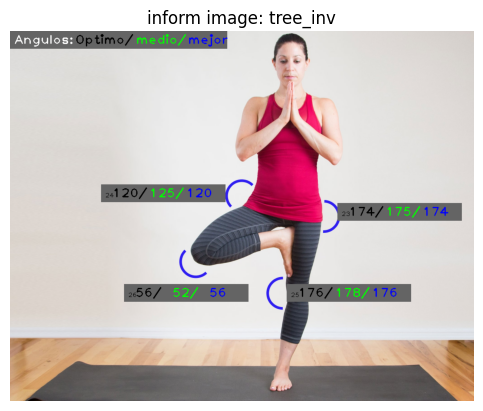

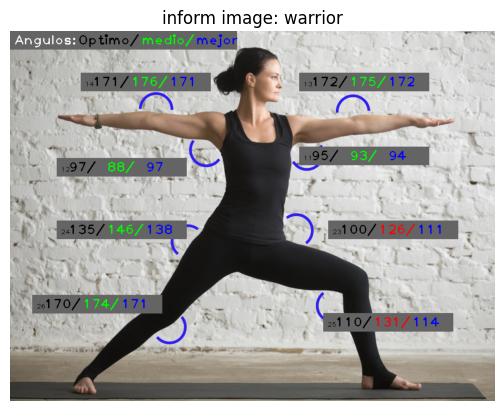

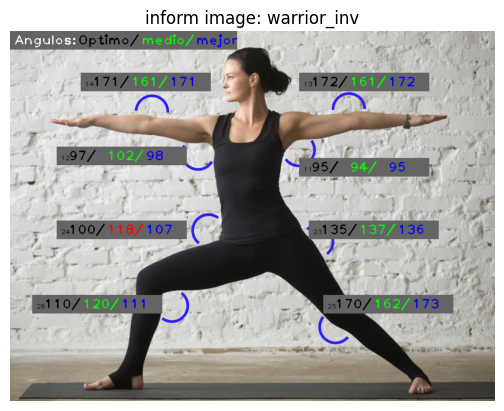

In [62]:
report_images(reporte_final, reporte_final['pose'].unique())